<a href="https://colab.research.google.com/github/manvendra7/E2S14/blob/main/Copy_of_BERT_Tutorial_How_To_Build_a_Question_Answering_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 123 kB 8.6 MB/s 
     |████████████████████████████████| 90 kB 11.4 MB/s 
     |████████████████████████████████| 176 kB 58.4 MB/s 
     |████████████████████████████████| 131 kB 63.9 MB/s 
     |████████████████████████████████| 895 kB 67.4 MB/s 
     |████████████████████████████████| 1.2 MB 44.4 MB/s 
     |████████████████████████████████| 7.8 MB 66.1 MB/s 
     |████████████████████████████████| 79 kB 9.8 MB/s 
     |████████████████████████████████| 138 kB 75.8 MB/s 
     |████████████████████████████████| 127 kB 71.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [6]:
!ls /drive/My\ Drive/Medium

dev-v2.0.json  train-v2.0.json	utils_squad_evaluate.py  utils_squad.py


In [7]:
import sys
sys.path.append('/drive/My Drive/Medium')

In [8]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
input_file = '/drive/My Drive/Medium/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [11]:
examples = examples[:26064]

In [12]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
#train_data = train_data.sample(frac=0.2)
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [13]:
train_data.shape

(26064, 7)

In [14]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
21435,56e8ea980b45c0140094cd61,What kind of church is Westminster Abbey?,"[Westminster, Abbey, is, a, collegiate, church...",collegiate church,4,5,False
21436,56e8ea980b45c0140094cd62,Who created Westminster Abbey as the Collegiat...,"[Westminster, Abbey, is, a, collegiate, church...",Queen Elizabeth I,20,22,False
21437,56e8ea980b45c0140094cd63,Who governs the church?,"[Westminster, Abbey, is, a, collegiate, church...",the Dean and Chapter of Westminster,8,13,False
21438,56e8ea980b45c0140094cd64,Who are the members of the chapter of Westmins...,"[Westminster, Abbey, is, a, collegiate, church...",the Dean and four canons residentiary,53,58,False
21439,56e8ea980b45c0140094cd65,Who assist the chapter of Westminster?,"[Westminster, Abbey, is, a, collegiate, church...",the Receiver General and Chapter Clerk,61,66,False
21440,5ad3f8b5604f3c001a3ffa7b,What kind of church isn't Westminster Abbey?,"[Westminster, Abbey, is, a, collegiate, church...",,-1,-1,True
21441,5ad3f8b5604f3c001a3ffa7c,Who hated Westminster Abbey as the Collegiate ...,"[Westminster, Abbey, is, a, collegiate, church...",,-1,-1,True
21442,5ad3f8b5604f3c001a3ffa7d,Who governs the school?,"[Westminster, Abbey, is, a, collegiate, church...",,-1,-1,True
21443,5ad3f8b5604f3c001a3ffa7e,Who aren't the members of the chapter of Westm...,"[Westminster, Abbey, is, a, collegiate, church...",,-1,-1,True
21444,5ad3f8b5604f3c001a3ffa7f,Who rejects the chapter of Westminster?,"[Westminster, Abbey, is, a, collegiate, church...",,-1,-1,True


In [15]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [16]:
print_squad_sample(train_data)

CONTEXT: 
The UK government has spent £250 million in the construction of the island's airport.
Expected to be fully operational early 2016, it is expected to help the island
towards self-sufficiency and encourage economic development, reducing dependence on British government aid. The airport
is also expected to kick start the tourism industry, with up to 30,000 visitors
expected annually. As of August, 2015 ticketing was postponed until an airline could be
firmly designated.
QUESTION:                                                                                            ANSWER:
How much money was spent on construction of the island's airport?                                    250 million
Which government built the island's airport?                                                         UK government
When was the airport expected to be fully functional?                                                early 2016
Which industry is the airport supposed to help when it becomes comple

In [17]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
13809,5ace05dc32bba1001ae4998b,"Along with Sakhalin Island, what islands were ...","[At, the, end, of, World, War, II, Soviet, tro...",,-1,-1,True,34,96
11526,56de67e0cffd8e1900b4b88a,What does 'TAMARI OSTIA' mean?,"[Upper, Palaeolithic, deposits,, including, bo...",mouth/estuaries of the Tamar,54,57,False,76,30
1335,56cfef3c234ae51400d9c10f,The Funeral March was written as part of what ...,"[Some, of, Chopin's, well-known, pieces, have,...",Sonata No. 2,102,104,False,136,52
12912,56df4c368bc80c19004e4a29,How many square miles is Oklahoma City?,"[According, to, the, United, States, Census, B...",620.34 square miles,14,16,False,47,39
4748,56d0fb7817492d1400aab6dd,At what age did Kanye West relocate to China?,"[At, the, age, of, 10,, West, moved, with, his...",10,4,4,False,76,45


In [18]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.77608962553714%


In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 953446.72B/s]


In [20]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 32

In [21]:
cached_features_file = '/drive/My Drive/Medium/cache_train'

In [22]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [23]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [24]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [25]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [26]:
import glob
checkpoints = sorted(glob.glob('/drive/My Drive/Medium/checkpoint*-[0-9]*'))

In [27]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [28]:
checkpoints

[]

In [29]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = '/drive/My Drive/Medium/checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

100%|██████████| 440473133/440473133 [00:10<00:00, 41571685.75B/s]


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [30]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[-0.0005, -0.0060, -0.0009,  ..., -0.0041, -0.0082, -0.0096],
        [-0.0053,  0.0101,  0.0138,  ...,  0.0166,  0.0042,  0.0201]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [31]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [32]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 500 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/drive/My Drive/Medium/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

Iteration:   0%|          | 0/877 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 28080
  Num Epochs = 1
  Batch size = 32
  Total optimization steps = 877


/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  57%|█████▋    | 500/877 [13:26<10:22,  1.65s/it]

Train loss: 1.746605106830597



Iteration:  57%|█████▋    | 501/877 [13:30<13:36,  2.17s/it]

Saving model checkpoint to /drive/My Drive/Medium/checkpoint-500



Epoch: 100%|██████████| 1/1 [23:51<00:00, 1431.11s/it]


In [33]:
output_dir = '/drive/My Drive/Medium/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [34]:
os.path.exists(output_dir)

True

In [68]:
# train_loss = []
# for i in train_loss_set:
# train_loss.append(i.item())
# print("Training Loss",train_loss[-1])

Training Loss 1.251854658126831


In [64]:
# train_loss_set_ckpt = torch.load('/drive/My Drive/Medium/checkpoint-final/training_loss.pt')
# train_loss_set = to_list(train_loss_set_ckpt)

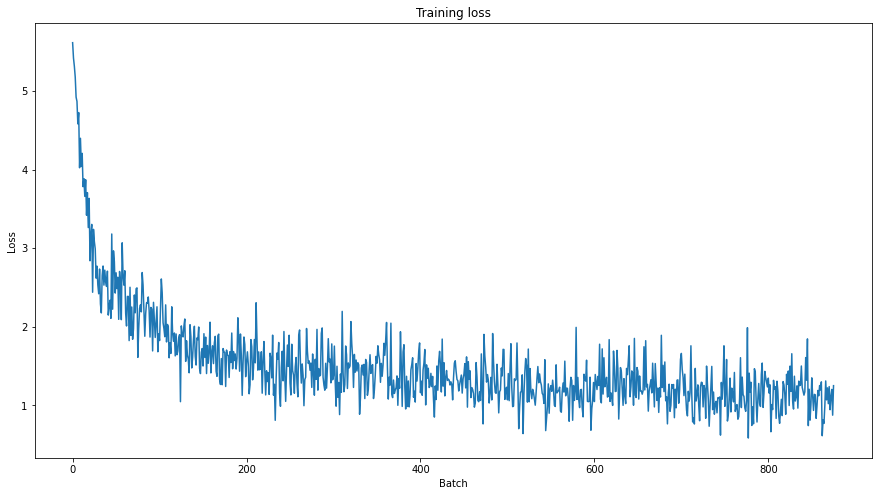

In [65]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [39]:
input_file = '/drive/My Drive/Medium/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/drive/My Drive/Medium/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [40]:
test_data = pd.DataFrame.from_records([vars(val_example) for val_example in val_examples])
#train_data = train_data.sample(frac=0.2)
test_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56ddde6b9a695914005b9628,In what country is Normandy located?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
1,56ddde6b9a695914005b9629,When were the Normans in Normandy?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
2,56ddde6b9a695914005b962a,From which countries did the Norse originate?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
3,56ddde6b9a695914005b962b,Who was the Norse leader?,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False
4,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,"[The, Normans, (Norman:, Nourmands;, French:, ...",None,None,None,False


In [43]:
test_data.shape

(11873, 7)

In [44]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [45]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [46]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/drive/My Drive/Medium//dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/drive/My Drive/Medium/predictions.json"
  output_nbest_file = "/drive/My Drive/Medium/nbest_predictions.json"
  output_null_log_odds_file = "/drive/My Drive/Medium/null_odds.json"
  output_dir = "/drive/My Drive/Medium/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [47]:
results = evaluate(model, tokenizer)

Evaluating:   0%|          | 0/425 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 32


Evaluating: 100%|██████████| 425/425 [03:37<00:00,  1.95it/s]


{
  "exact": 49.38937084140487,
  "f1": 54.0109620487612,
  "total": 11873,
  "HasAns_exact": 64.6255060728745,
  "HasAns_f1": 73.88194203862014,
  "HasAns_total": 5928,
  "NoAns_exact": 34.19680403700589,
  "NoAns_f1": 34.19680403700589,
  "NoAns_total": 5945,
  "best_exact": 57.01170723490272,
  "best_exact_thresh": -5.869788765907288,
  "best_f1": 59.45140875382585,
  "best_f1_thresh": -5.801982164382935
}


In [48]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 49.38937084140487}, {'f1': 54.0109620487612}, {'total': 11873}, {'HasAns_exact': 64.6255060728745}, {'HasAns_f1': 73.88194203862014}, {'HasAns_total': 5928}, {'NoAns_exact': 34.19680403700589}, {'NoAns_f1': 34.19680403700589}, {'NoAns_total': 5945}, {'best_exact': 57.01170723490272}, {'best_exact_thresh': -5.869788765907288}, {'best_f1': 59.45140875382585}, {'best_f1_thresh': -5.801982164382935}]


**Evaluate on any text**

In [50]:

with open('/drive/My Drive/Medium/predictions.json') as f:
    best_predictions = json.load(f)

In [54]:
import random

for example in random.sample(val_examples, 10):
    qas_id = example.qas_id
    question_text = example.question_text
    answer_text = best_predictions[qas_id]
    print("*"*90)
    print()
    print(f'question         >> {question_text}')
    print(f'Answer BY Model  >> {answer_text}')
    print()
    print("*"*90)


******************************************************************************************

question         >> What was the Grand 1401 building renamed as?
Answer BY Model  >> San Joaquin Light & Power Building

******************************************************************************************
******************************************************************************************

question         >> What is the result of rebellion according to Black's Law Dictionary?
Answer BY Model  >> non-violence

******************************************************************************************
******************************************************************************************

question         >> Who was the first geologist?
Answer BY Model  >> James Hutton

******************************************************************************************
******************************************************************************************

question         >> What does no